In [1]:
import pickle
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from sklearn.manifold import TSNE
from linclab_utils import plot_utils
from connectome_to_model.utils.datagen import *
import torchvision.transforms as T
from torchvision import datasets

from ambiguous.dataset.dataset import DatasetFromNPY, DatasetTriplet, SequenceDataset, SequenceEMNIST
from torch.utils.data import DataLoader, Subset, Dataset
from connectome_to_model.utils.audio_dataset import AudioVisualDataset
from connectome_to_model.model.graph import Graph, Architecture

In [2]:
def extract_mean_and_std(list_of_dict, num_epochs):
    mean_array = np.zeros((4, 2, num_epochs))
    
    for i, result in enumerate(['amb_match_acc', 'clean_mismatch_acc', 'ambimg_acc', 'ambimg_audio_align']):
        array = np.zeros((len(list_of_dict), num_epochs))
        for trial_num, run in enumerate(list_of_dict):
            array[trial_num] = run[result]
        
        mean_array[i][0] = np.mean(array, axis=0) 
        mean_array[i][1] = np.std(array, axis=0)
    
    return mean_array

In [3]:
def extract_mean_and_std_V2(list_of_dict, num_epochs, scenarios=None):
    if scenarios == None:
        scenarios = ['amb_match_acc', 'clean_mismatch_acc', 'control_img_align', 'control_audio_align', 'allamb_img_align', 'allamb_audio_align']
    mean_array = np.zeros((len(scenarios), 2, num_epochs))
    
    for i, result in enumerate(scenarios):
        array = np.zeros((len(list_of_dict), num_epochs))
        for trial_num, run in enumerate(list_of_dict):
            array[trial_num] = run[result]
        
        mean_array[i][0] = np.mean(array, axis=0) 
        mean_array[i][1] = np.std(array, axis=0)
    
    return mean_array

In [4]:
def make_error_plot(ax, graphs, labels, colors, test_idx, epochs=50):
    x = np.arange(0, epochs)
    for i, graph in enumerate(graphs):
        if colors[i] != 'purple' and colors[i] !='orange':
            alpha=0.1
        else:
            alpha=0.3
        ax.fill_between(x, graph[test_idx][0]-graph[test_idx][1], 
                 graph[test_idx][0]+graph[test_idx][1], color=colors[i], alpha=alpha)
        ax.plot(graph[test_idx][0], label=labels[i], color=colors[i])

In [5]:
def extract_final_epoch(scenario='amb_match_acc', final_epoch=49):
    means_mult_brainlike = [topdown_thickness[i][scenario][final_epoch] for i in range(len(topdown_thickness))]
    means_comp_brainlike = [topdown_thickness_comp[i][scenario][final_epoch] for i in range(len(topdown_thickness_comp))]

    means_mult_mpc = [topdown_mpc[i][scenario][final_epoch] for i in range(len(topdown_mpc))]
    means_comp_mpc = [topdown_mpc_comp[i][scenario][final_epoch] for i in range(len(topdown_mpc_comp))]

    means_mult_rand = [topdown_rand2[i][scenario][final_epoch] for i in range(len(topdown_rand2))]
    for i in range(len(topdown_rand1)):  
        means_mult_rand.append(topdown_rand1[i][scenario][final_epoch])
    for i in range(len(topdown_rand3)):
        means_mult_rand.append(topdown_rand3[i][scenario][final_epoch])
    
    means_comp_rand = [topdown_rand2_comp[i][scenario][final_epoch] for i in range(len(topdown_rand2_comp))]
    for i in range(len(topdown_rand1_comp)):
        means_comp_rand.append(topdown_rand1_comp[i][scenario][final_epoch])
    for i in range(len(topdown_rand3_comp)):
        means_comp_rand.append(topdown_rand3_comp[i][scenario][final_epoch])
        
    means_mult = [means_mult_brainlike, means_mult_mpc, means_mult_rand]
    means_comp = [means_comp_brainlike, means_comp_mpc, means_comp_rand]
    
    return means_mult, means_comp

In [6]:
def boxplot_mult_vs_comp(mult, comp, baseline = None, title='VS1'):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create box plots for means_a
    boxprops_a = dict(facecolor='purple', edgecolor='black', linewidth=None)
    ax.boxplot(mult[0], positions=[0], patch_artist=True, boxprops=boxprops_a)

    boxprops_b = dict(facecolor='purple', edgecolor='black', linewidth=None)
    ax.boxplot(comp[0], positions=[0.2], patch_artist=True, boxprops=boxprops_b)

    boxprops_a = dict(facecolor='orange', edgecolor='black', linewidth=None)
    ax.boxplot(mult[1], positions=[1], patch_artist=True, boxprops=boxprops_a)

    boxprops_b = dict(facecolor='orange', edgecolor='black', linewidth=None)
    ax.boxplot(comp[1], positions=[1.2], patch_artist=True, boxprops=boxprops_b)

    boxprops_a = dict(facecolor='gray', edgecolor='black', linewidth=None)
    ax.boxplot(mult[2], positions=[2], patch_artist=True, boxprops=boxprops_a)

    boxprops_b = dict(facecolor='gray', edgecolor='black', linewidth=None)
    ax.boxplot(comp[2], positions=[2.2], patch_artist=True, boxprops=boxprops_b)
    
    # Set baseline if it exists
    if baseline != None:
        x = [-0.5, 2.5]
        ax.plot(x, [baseline]*2, color='#59B9D2', linestyle='--')

    # Set labels and title
    ax.set_xticklabels(['Mult', 'Comp', 'Mult', 'Comp', 'Mult', 'Comp'])
    ax.set_ylabel('Final epoch accuracy')
    ax.set_title(title)
    #ax.set_ylim([0.6, 1.0])

    # Show the plot
    plt.savefig('figs/fig4_boxplots_wFF/%s.pdf'%title)
    plt.show()

## Sequence examples

In [7]:
dataset = AudioVisualDataset(None, None, cache_dir='/home/mila/m/mashbayar.tugsbayar/datasets/multimodal_amb_match')

In [28]:
dataset[0][1][0]

tensor(8, dtype=torch.uint8)

In [7]:
MNIST_path='../datasets/torchvision/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.ToTensor()
clean_train_data = datasets.MNIST(root=MNIST_path, download=True, train=True, transform=transform)

# Label references, which help generate sequences
mnist_ref_train = generate_label_reference(clean_train_data)

# Create dataloaders
amb_trainset = DatasetTriplet('/home/mila/m/mashbayar.tugsbayar/datasets/amnistV2', split='train')
ambiguous_train = DataLoader(amb_trainset, batch_size=64, shuffle=True)
clean_train_dataloader = DataLoader(clean_train_data, batch_size=64, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [9]:
MNIST_path='../datasets/torchvision/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.ToTensor()
clean_train_data = datasets.MNIST(root=MNIST_path, download=True, train=True, transform=transform)

# Label references, which help generate sequences
mnist_ref_train = generate_label_reference(clean_train_data)

# Create dataloaders
amb_trainset = SequenceEMNIST('/network/scratch/m/mashbayar.tugsbayar/datasets/aemnistV4', split='train', cache=False, ambiguous=False, 
                               cache_dir='/network/scratch/m/mashbayar.tugsbayar/datasets/emnist_seq')
ambiguous_train = DataLoader(amb_trainset, batch_size=64, shuffle=True)
#clean_train_dataloader = DataLoader(clean_train_data, batch_size=64, shuffle=True)

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
X, t = next(iter(ambiguous_train))
#pick = np.random.binomial(1, 0.5)
#x, t = x[1].to(device), t[:, pick].to(device)
#input_seqs = sequence_gen(x, t, clean_train_data, mnist_ref_train, seq_style='addition', show=True)

In [13]:
t = /home/mila/m/mashbayar.tugsbayar/convgru_feedback/generated

tensor(11, dtype=torch.uint8)

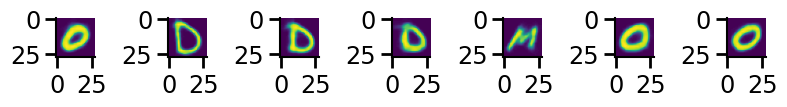

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 7
rows = 1
for i in range(columns):
    img = X[0][i][0].cpu().detach()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

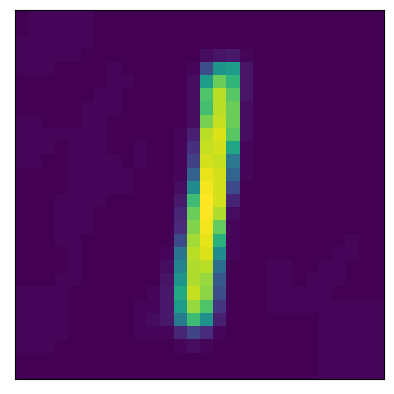

In [26]:
#x, _ = next(iter(clean_train_dataloader))
fig = plt.figure()
x = X[0][2][0].cpu().detach()
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.imshow(x)
plt.show()

## Topdown clue only test

In [3]:
topdown_comp = pd.read_pickle('results/topdown_tests/topdown_only/topdown_only_comp.npy')
topdown_basal = pd.read_pickle('results/topdown_tests/topdown_only/topdown_only_noupsampling_basal.npy')
topdown_mult = pd.read_pickle('results/topdown_tests/topdown_only_noupsampling_mult.npy')
topdown_basal10 = pd.read_pickle('results/topdown_tests/topdown_only/topdown_only_noupsampling_basal10.npy')
all_topdown = pd.read_pickle('results/topdown_tests/topdown_only/topdown_only_noupsampling_all.npy')
no_topdown = pd.read_pickle('results/topdown_tests/topdown_only_noupsampling_control.npy')

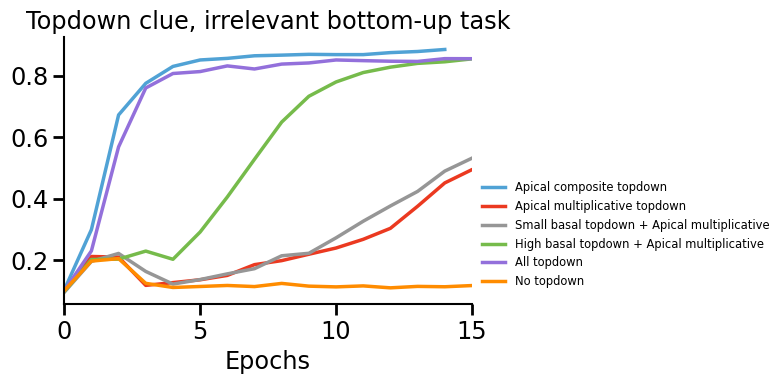

In [22]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
ax1.plot(topdown_comp['val_acc'], label='Apical composite topdown')
ax1.plot(topdown_mult['val_acc'], label='Apical multiplicative topdown')
ax1.plot(topdown_basal['val_acc'], label='Small basal topdown + Apical multiplicative')
ax1.plot(topdown_basal10['val_acc'], label='High basal topdown + Apical multiplicative')
ax1.plot(all_topdown['val_acc'], label='All topdown')
ax1.plot(no_topdown['val_acc'], label='No topdown')
plt.title('Topdown clue, irrelevant bottom-up task')
#plt.xticks(np.arange(0, 2000, step=200))
#ax1.set_title('ConvGrU image topdown')
#ax2.set_title('ConvGrU audio topdown')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
ax1.set_xlim([0, 15])
#ax2.set_x_label('epochs')
#ax2.set_y_label('accuracy')
plt.xlabel('Epochs')
plt.show()

# Ambiguous image recovery through audio top-down

In [13]:
topdown_comp = pd.read_pickle('results/topdown_tests/audio_recovery/apical1_noupsampling.npy')
topdown_basal = pd.read_pickle('results/topdown_tests/audio_recovery/basal1_noupsampling.npy')
topdown_basal10 = pd.read_pickle('results/topdown_tests/audio_recovery/basal10_noupsampling.npy')
topdown_mult = pd.read_pickle('results/topdown_tests/audio_recovery/mult_only_noupsampling.npy')
all_topdown = pd.read_pickle('results/topdown_tests/audio_recovery/all_noupsampling.npy')
no_topdown = pd.read_pickle('results/topdown_tests/audio_recovery/notopdown.npy')

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


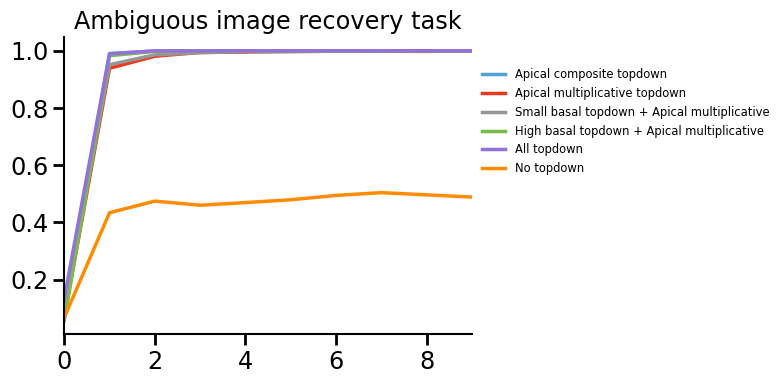

In [14]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
ax1.plot(topdown_comp['val_acc'], label='Apical composite topdown')
ax1.plot(topdown_mult['val_acc'], label='Apical multiplicative topdown')
ax1.plot(topdown_basal['val_acc'], label='Small basal topdown + Apical multiplicative')
ax1.plot(topdown_basal10['val_acc'], label='High basal topdown + Apical multiplicative')
ax1.plot(all_topdown['val_acc'], label='All topdown')
ax1.plot(no_topdown['val_acc'], label='No topdown')
plt.title('Ambiguous image recovery task')
#plt.xticks(np.arange(0, 2000, step=200))
#ax1.set_title('ConvGrU image topdown')
#ax2.set_title('ConvGrU audio topdown')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
ax1.set_xlim([0, 9])
#ax2.set_x_label('epochs')
#ax2.set_y_label('accuracy')
#plt.xlabel('Epochs')
plt.show()

In [3]:
topdown_comp = pd.read_pickle('results/audio_recovery_per-step/apical1_noupsampling.npy')
topdown_basal10 = pd.read_pickle('results/audio_recovery_per-step/basal10_noupsampling.npy')
topdown_mult = pd.read_pickle('results/audio_recovery_per-step/mult_noupsampling.npy')
all_topdown = pd.read_pickle('results/audio_recovery_per-step/all_noupsampling.npy')
#no_topdown = pd.read_pickle('results/audio_recovery_per-step/notopdown.npy')

In [6]:
topdown_comp

{'loss': [4303.375082731247, 3997.518509030342],
 'train_acc': [0.0993, 0.18656666666666666],
 'val_acc': [0.1032, 0.1563]}

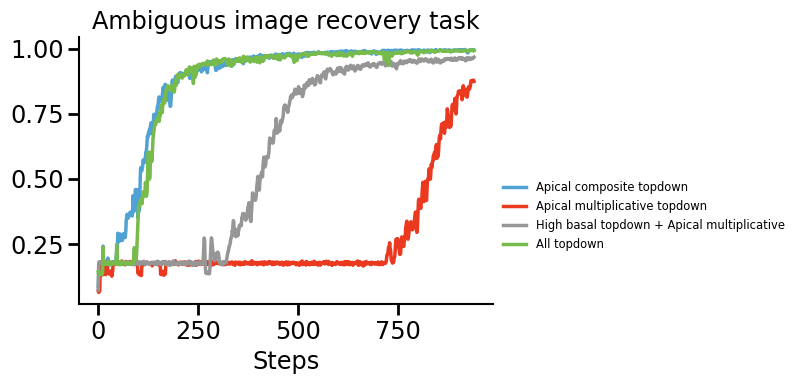

In [12]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
ax1.plot(topdown_comp['val_acc'][0], label='Apical composite topdown')
ax1.plot(topdown_mult['val_acc'][0], label='Apical multiplicative topdown')
ax1.plot(topdown_basal10['val_acc'][0], label='High basal topdown + Apical multiplicative')
ax1.plot(all_topdown['val_acc'][0], label='All topdown')
#ax1.plot(no_topdown['val_acc'], label='No topdown')
plt.title('Ambiguous image recovery task')
#plt.xticks(np.arange(0, 2000, step=200))
#ax1.set_title('ConvGrU image topdown')
#ax2.set_title('ConvGrU audio topdown')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
#ax1.set_xlim([0, 9])
#ax2.set_x_label('epochs')
#ax2.set_y_label('accuracy')
plt.xlabel('Steps')
plt.show()

## Audio Recovery with Clean Mismatch Cases

In [4]:
topdown_comp = []
topdown_mult = []
topdown_basal = []
topdown_all = []

for i in range(1, 5):
    topdown_mult.append(pd.read_pickle('results/audio_recovery_wmismatch/mult_{:1d}.npy'.format(i)))
    topdown_comp.append(pd.read_pickle('results/audio_recovery_wmismatch/apical1_{:1d}.npy'.format(i)))
    topdown_basal.append(pd.read_pickle('results/audio_recovery_wmismatch/basal10_{:1d}.npy'.format(i)))
    topdown_all.append(pd.read_pickle('results/audio_recovery_wmismatch/all_{:1d}.npy'.format(i)))

In [4]:
topdown_comp_mean = extract_mean_and_std(topdown_comp, 20)
topdown_mult_mean = extract_mean_and_std(topdown_mult, 20)
topdown_basal_mean = extract_mean_and_std(topdown_basal, 20)
topdown_all_mean = extract_mean_and_std(topdown_all, 20)

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


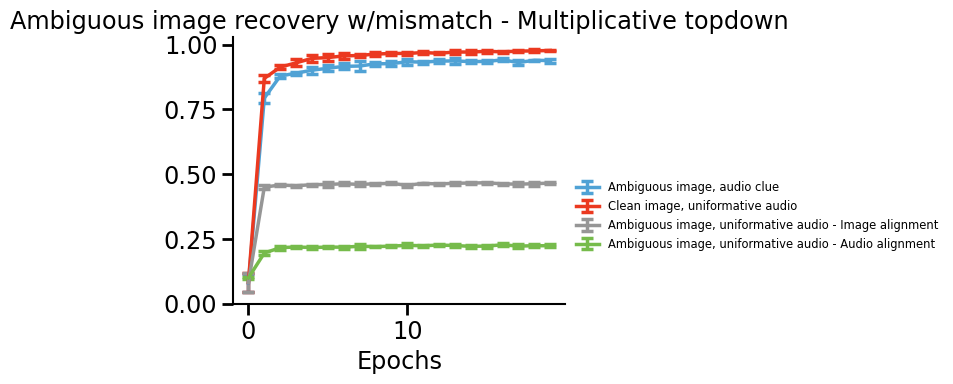

In [21]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
x = np.arange(0, 20)
ax1.errorbar(x, topdown_mult_mean[0][0], yerr= topdown_mult_mean[0][1], label='Ambiguous image, audio clue')
ax1.errorbar(x, topdown_mult_mean[1][0], yerr= topdown_mult_mean[1][1], label='Clean image, uniformative audio')
ax1.errorbar(x, topdown_mult_mean[2][0], yerr= topdown_mult_mean[2][1], label='Ambiguous image, uniformative audio - Image alignment')
ax1.errorbar(x, topdown_mult_mean[3][0], yerr= topdown_mult_mean[3][1], label='Ambiguous image, uniformative audio - Audio alignment')
plt.title('Ambiguous image recovery w/mismatch - Multiplicative topdown')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.xlabel('Epochs')
plt.show()

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


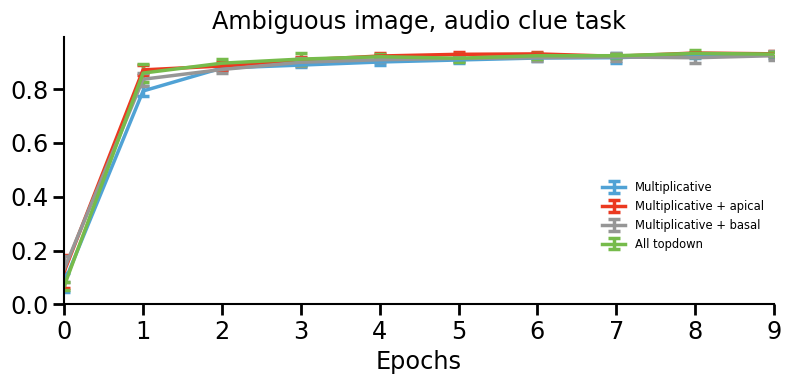

In [38]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
x = np.arange(0, 20)
ax1.errorbar(x, topdown_mult_mean[0][0], yerr= topdown_mult_mean[0][1], label='Multiplicative')
ax1.errorbar(x, topdown_comp_mean[0][0], yerr= topdown_comp_mean[0][1], label='Multiplicative + apical')
ax1.errorbar(x, topdown_basal_mean[0][0], yerr= topdown_basal_mean[0][1], label='Multiplicative + basal')
ax1.errorbar(x, topdown_all_mean[0][0], yerr= topdown_all_mean[0][1], label='All topdown')
plt.title('Ambiguous image, audio clue task')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.xlabel('Epochs')
ax1.set_xlim([0, 9])
plt.show()

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


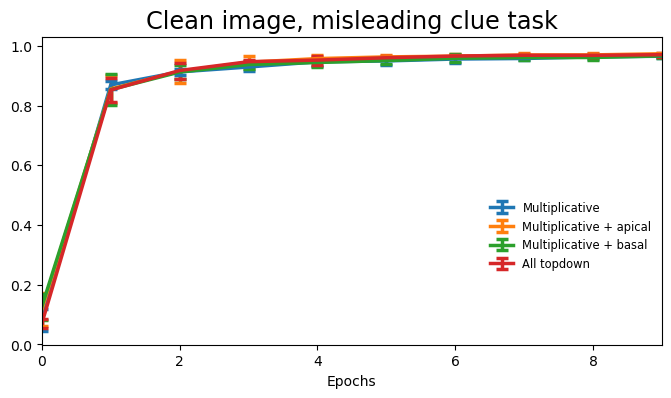

In [5]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
x = np.arange(0, 20)
ax1.errorbar(x, topdown_mult_mean[1][0], yerr= topdown_mult_mean[1][1], label='Multiplicative')
ax1.errorbar(x, topdown_comp_mean[1][0], yerr= topdown_comp_mean[1][1], label='Multiplicative + apical')
ax1.errorbar(x, topdown_basal_mean[1][0], yerr= topdown_basal_mean[1][1], label='Multiplicative + basal')
ax1.errorbar(x, topdown_all_mean[1][0], yerr= topdown_all_mean[1][1], label='All topdown')
plt.title('Clean image, misleading clue task')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.xlabel('Epochs')
ax1.set_xlim([0, 9])
plt.show()

/home/mila/m/mashbayar.tugsbayar/.conda/envs/nnet/lib/python3.9/site-packages/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


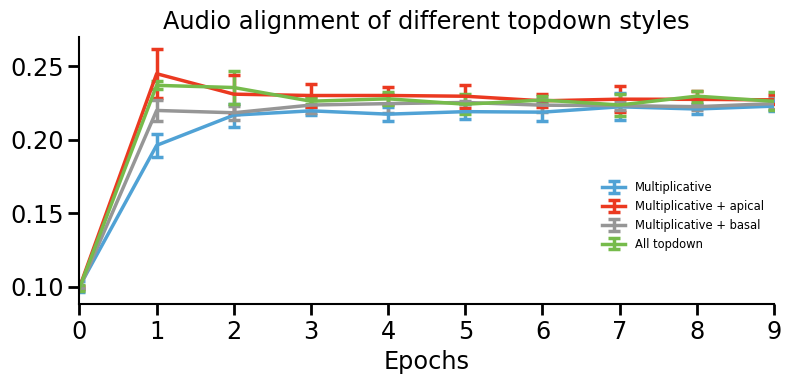

In [35]:
fig, ax1 = plt.subplots(figsize=(8,4))
plot_utils.linclab_plt_defaults()
x = np.arange(0, 20)
ax1.errorbar(x, topdown_mult_mean[3][0], yerr= topdown_mult_mean[3][1], label='Multiplicative')
ax1.errorbar(x, topdown_comp_mean[3][0], yerr= topdown_comp_mean[3][1], label='Multiplicative + apical')
ax1.errorbar(x, topdown_basal_mean[3][0], yerr= topdown_basal_mean[3][1], label='Multiplicative + basal')
ax1.errorbar(x, topdown_all_mean[3][0], yerr= topdown_all_mean[3][1], label='All topdown')
plt.title('Audio alignment of different topdown styles')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.xlabel('Epochs')
ax1.set_xlim([0, 9])
plt.show()

## Simple image recognition

In [10]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []

for i in range(1, 5):
    topdown_thickness.append(pd.read_pickle('results/image_benchmark/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/image_benchmark/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/image_benchmark/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/image_benchmark/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/image_benchmark/random3_{:1d}.npy'.format(i)))

In [11]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 30, scenarios=['match_acc'])
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 30, scenarios=['match_acc'])
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 30, scenarios=['match_acc'])
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 30, scenarios=['match_acc'])
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 30, scenarios=['match_acc'])

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


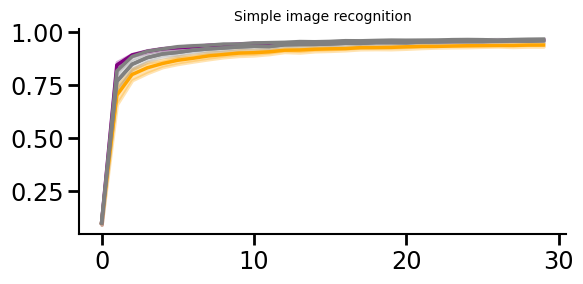

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand3_stats, topdown_rand3_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph']

make_error_plot(ax1, graphs, labels, colors, test_idx=0, epochs=30)
#ax1.set_ylim(0.7, 1.0)
#make_error_plot(ax2, graphs, labels, colors, test_idx=1)
#make_error_plot(ax3, graphs, labels, colors, test_idx=2)
#make_error_plot(ax4, graphs, labels, colors, test_idx=3)

ax1.set_title('Simple image recognition', fontsize='small')
#ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
#ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
#ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')

#plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/simple_image.pdf')
plt.show()

## Simple audio recognition

In [60]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []
topdown_mff = []

for i in range(1, 7):
    topdown_thickness.append(pd.read_pickle('results/audio_benchmark/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/audio_benchmark/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/audio_benchmark/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/audio_benchmark/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/audio_benchmark/random3_{:1d}.npy'.format(i)))
    topdown_mff.append(pd.read_pickle('results/audio_benchmark/big_rnn_{:1d}.npy'.format(i)))

In [61]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 30, scenarios=['match_acc'])
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 30, scenarios=['match_acc'])
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 30, scenarios=['match_acc'])
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 30, scenarios=['match_acc'])
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 30, scenarios=['match_acc'])
topdown_mff_stats = extract_mean_and_std_V2(topdown_mff, 30, scenarios=['match_acc'])

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


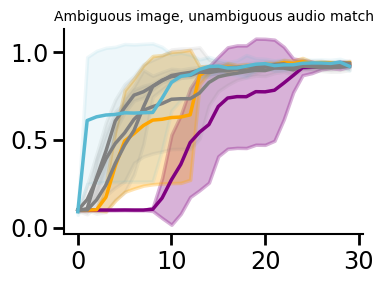

In [62]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,3))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'ALL FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0, epochs=30)
#make_error_plot(ax2, graphs, labels, colors, test_idx=1)
#make_error_plot(ax3, graphs, labels, colors, test_idx=2)
#make_error_plot(ax4, graphs, labels, colors, test_idx=3)

ax1.set_title('Ambiguous image, unambiguous audio match', fontsize='small')
#ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
#ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
#ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')

#plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/simple_audio.pdf')
plt.show()

## Audio-Assisted Image Recovery w/Biological Graphs

In [22]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []
topdown_mfb = []
topdown_mff = []

for i in range(1, 8):
    topdown_thickness.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/random3_{:1d}.npy'.format(i)))
    #topdown_mfb.append(pd.read_pickle('results/audio_recovery_brainlike/thickness/mutual_fb_{:1d}.pt'.format(i)))
    topdown_mff.append(pd.read_pickle('results/audio_recovery_brainlike/big_rnn_{:1d}.npy'.format(i)))

In [23]:
topdown_thickness_stats = extract_mean_and_std(topdown_thickness, 50)
topdown_mpc_stats = extract_mean_and_std(topdown_mpc, 50)
topdown_rand1_stats = extract_mean_and_std(topdown_rand1, 50)
topdown_rand2_stats = extract_mean_and_std(topdown_rand2, 50)
topdown_rand3_stats = extract_mean_and_std(topdown_rand3, 50)
#topdown_mfb_stats = extract_mean_and_std(topdown_mfb, 50)
topdown_mff_stats = extract_mean_and_std(topdown_mff, 50)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


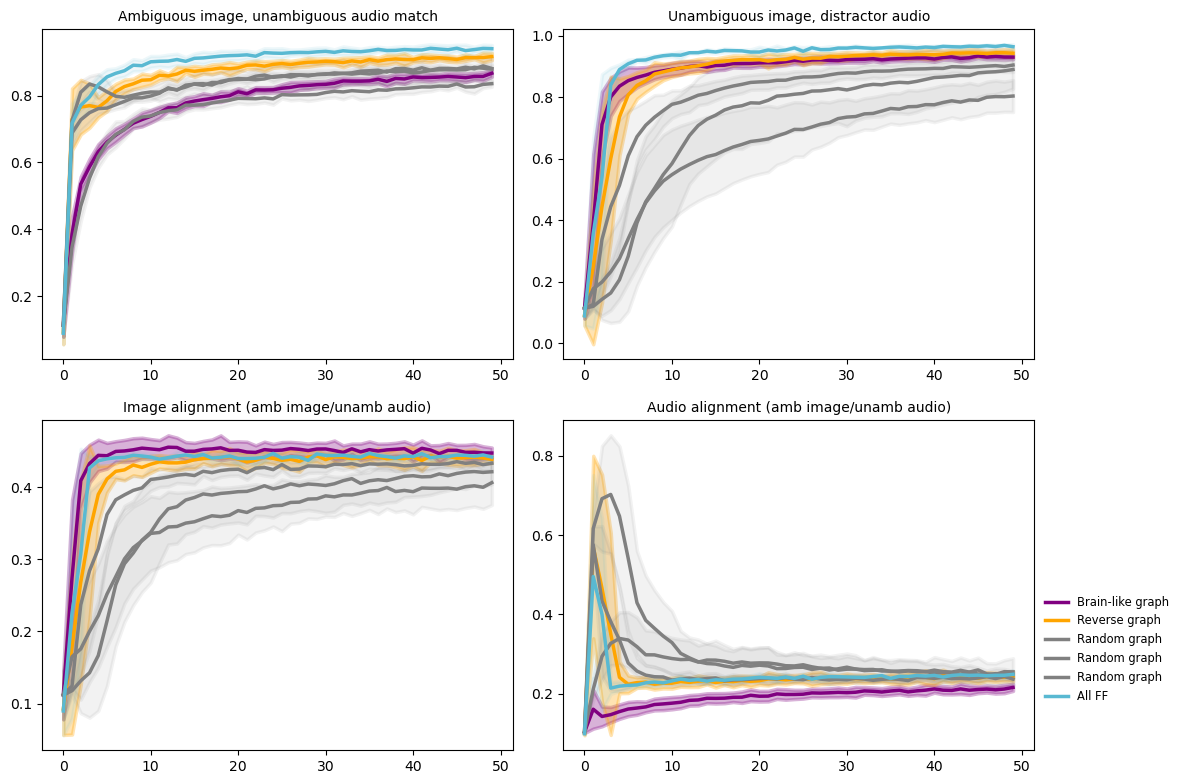

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'All FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)

ax1.set_title('Ambiguous image, unambiguous audio match', fontsize='small')
ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/img_recovery_mult.pdf')
plt.show()

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


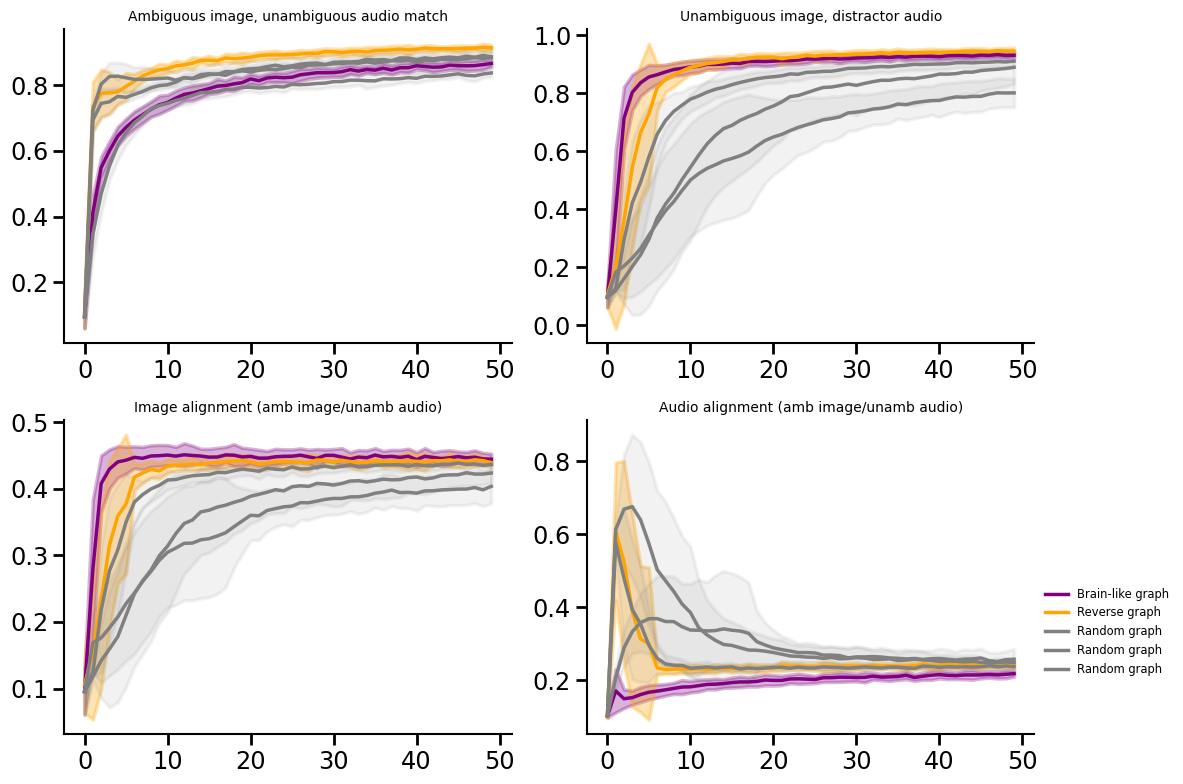

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray']
labels = ['Brain-like graph', 'Reverse graph', 'Random graph', 'Random graph', 'Random graph']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)

ax1.set_title('Ambiguous image, unambiguous audio match', fontsize='small')
ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/img_recovery_mult.pdf')
plt.show()

### Composite

In [24]:
topdown_thickness_comp = []
topdown_mpc_comp = []
topdown_rand1_comp = []
topdown_rand2_comp = []
topdown_rand3_comp = []

for i in range(5, 11):
    topdown_thickness_comp.append(pd.read_pickle('results/ambimg_composite_mfcc/thickness_{:1d}.npy'.format(i)))
    topdown_mpc_comp.append(pd.read_pickle('results/ambimg_composite_mfcc/MPC_{:1d}.npy'.format(i)))
    topdown_rand1_comp.append(pd.read_pickle('results/ambimg_composite_mfcc/random1_{:1d}.npy'.format(i)))
    topdown_rand2_comp.append(pd.read_pickle('results/ambimg_composite_mfcc/random2_{:1d}.npy'.format(i)))
    topdown_rand3_comp.append(pd.read_pickle('results/ambimg_composite_mfcc/random3_{:1d}.npy'.format(i)))

In [25]:
topdown_thickness_stats_comp = extract_mean_and_std_V2(topdown_thickness_comp, 50)
topdown_mpc_stats_comp = extract_mean_and_std_V2(topdown_mpc_comp, 50)
topdown_rand1_stats_comp = extract_mean_and_std_V2(topdown_rand1_comp, 50)
topdown_rand2_stats_comp = extract_mean_and_std_V2(topdown_rand2_comp, 50)
topdown_rand3_stats_comp = extract_mean_and_std_V2(topdown_rand3_comp, 50)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


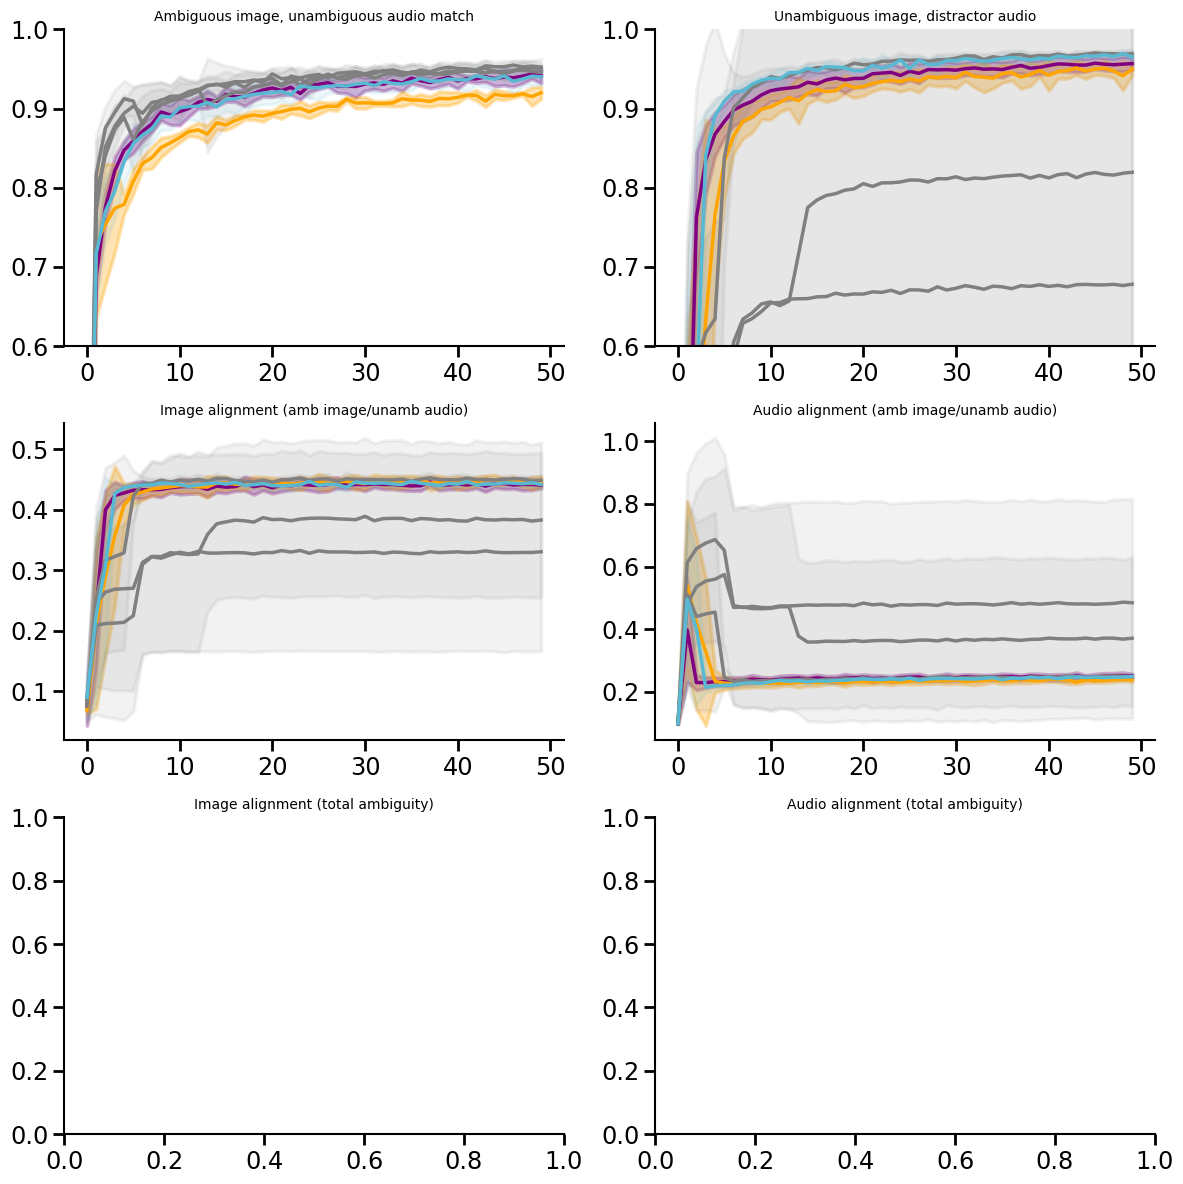

In [70]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats_comp, topdown_mpc_stats_comp, topdown_rand1_stats_comp, topdown_rand2_stats_comp, topdown_rand3_stats_comp, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'ALL FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
#make_error_plot(ax5, graphs, labels, colors, test_idx=4)
#make_error_plot(ax6, graphs, labels, colors, test_idx=5)

ax1.set_ylim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)
ax5.set_ylim(0, 1.0)
ax6.set_ylim(0, 1.0)

ax1.set_title('Ambiguous image, unambiguous audio match', fontsize='small')
ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/img_tasks_composite_mel.pdf')
plt.show()

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


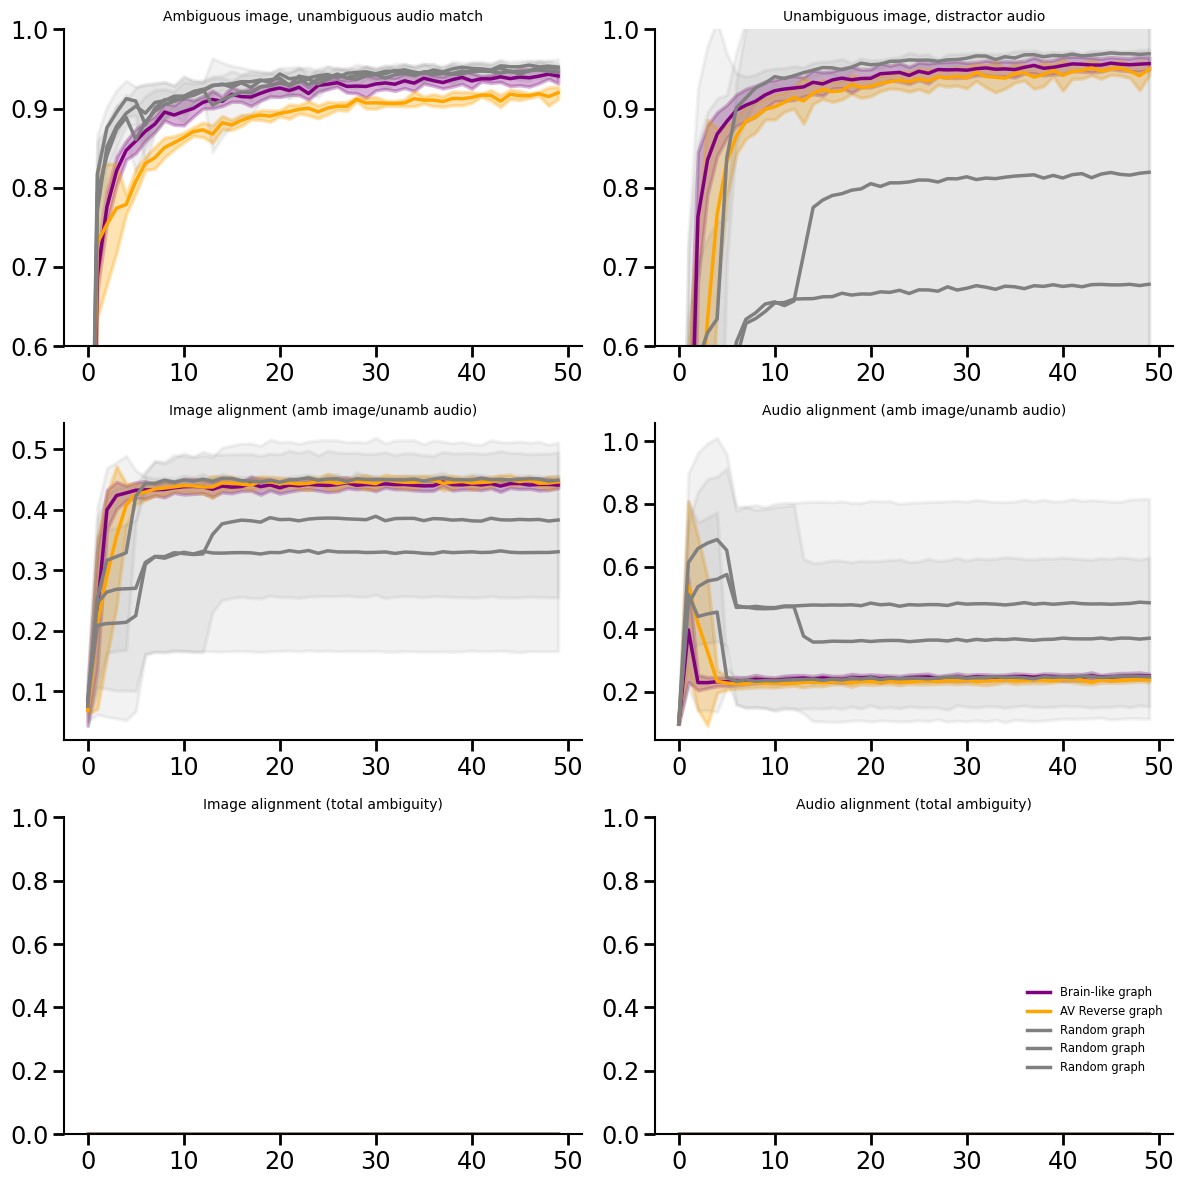

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
make_error_plot(ax5, graphs, labels, colors, test_idx=4)
make_error_plot(ax6, graphs, labels, colors, test_idx=5)

ax1.set_ylim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)
ax5.set_ylim(0, 1.0)
ax6.set_ylim(0, 1.0)

ax1.set_title('Ambiguous image, unambiguous audio match', fontsize='small')
ax2.set_title('Unambiguous image, distractor audio', fontsize='small')
ax3.set_title('Image alignment (amb image/unamb audio)', fontsize='small')
ax4.set_title('Audio alignment (amb image/unamb audio)', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('figs/img_tasks_composite_mel.pdf')
plt.show()

### Comparision

In [6]:
import scipy

In [19]:
topdown_mff_stats[0][0][49]

0.9379019213319132

In [26]:
means_mult, means_comp = extract_final_epoch('amb_match_acc')

In [9]:
scipy.stats.ttest_ind(means_mult[0], means_comp[0], equal_var=False)

TtestResult(statistic=-13.470769161705634, pvalue=3.5680290406327004e-08, df=10.985043642077146)

In [11]:
scipy.stats.ttest_ind(means_mult[1], means_comp[1], equal_var=False)

TtestResult(statistic=-1.2818657871687507, pvalue=0.22432816597137908, df=11.886758205449818)

In [14]:
scipy.stats.ttest_ind(means_mult[2], means_comp[2], equal_var=False)

TtestResult(statistic=-12.358311114367137, pvalue=9.9283447602552e-13, df=27.44829936934186)

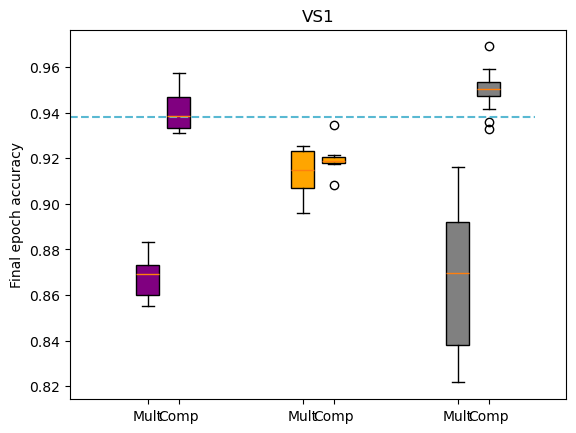

In [27]:
boxplot_mult_vs_comp(means_mult, means_comp, baseline = topdown_mff_stats[0][0][49], title='VS1')

#### VS2

In [28]:
means_mult, means_comp = extract_final_epoch('clean_mismatch_acc')

In [16]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[0], means_comp[0], equal_var=False)

TtestResult(statistic=-5.516348807966068, pvalue=0.00016816109742974128, df=11.239059725610701)

In [17]:
scipy.stats.ttest_ind(means_mult[1], means_comp[1], equal_var=False)

TtestResult(statistic=-0.9181675867543881, pvalue=0.3768265872150073, df=11.859568807366337)

In [18]:
scipy.stats.ttest_ind(means_mult[2], means_comp[2], equal_var=False)

TtestResult(statistic=0.5617245917363289, pvalue=0.581221525973795, df=18.025574132475228)

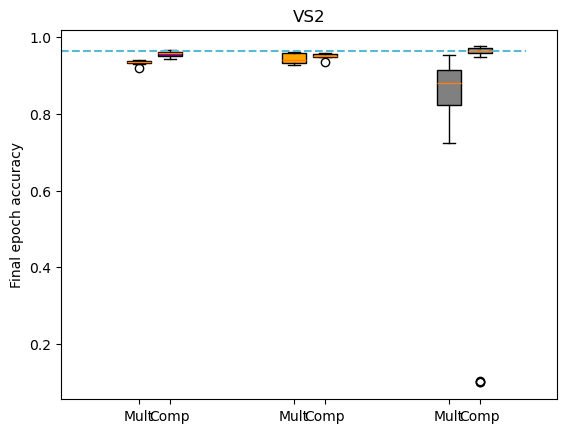

In [29]:
boxplot_mult_vs_comp(means_mult, means_comp, baseline = topdown_mff_stats[1][0][49], title='VS2')

## Image-assisted Auditory Task

Primarily auditory task where output is taken from A4 (part of Wernicke's area) and the model is trained to primarily identify the audio stimulus.

In [7]:
topdown_mpc = pd.read_pickle('results/audio_recovery_brainlike/biological_MPC.npy')
topdown_thickness = pd.read_pickle('results/audio_recovery_brainlike/thickness_full.npy')
topdown_random = pd.read_pickle('results/audio_recovery_brainlike/random.npy')
topdown_random2 = pd.read_pickle('results/audio_recovery_brainlike/random2.npy')
topdown_random3 = pd.read_pickle('results/audio_recovery_brainlike/random3.npy')

In [30]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []
topdown_mfb = []
topdown_mff = []

for i in range(1, 10):
    topdown_thickness.append(pd.read_pickle('results/ambaudio_extra_trial/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/ambaudio_brainlike/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/ambaudio_extra_trial/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/ambaudio_extra_trial/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/ambaudio_extra_trial/random3_{:1d}.npy'.format(i)))
    topdown_mff.append(pd.read_pickle('results/ambaudio_brainlike/big_rnn_{:1d}.npy'.format(i)))

In [31]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 50)
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 50)
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 50)
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 50)
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 50)
#topdown_mfb_stats = extract_mean_and_std_V2(topdown_mfb, 50)
topdown_mff_stats = extract_mean_and_std_V2(topdown_mff, 50)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


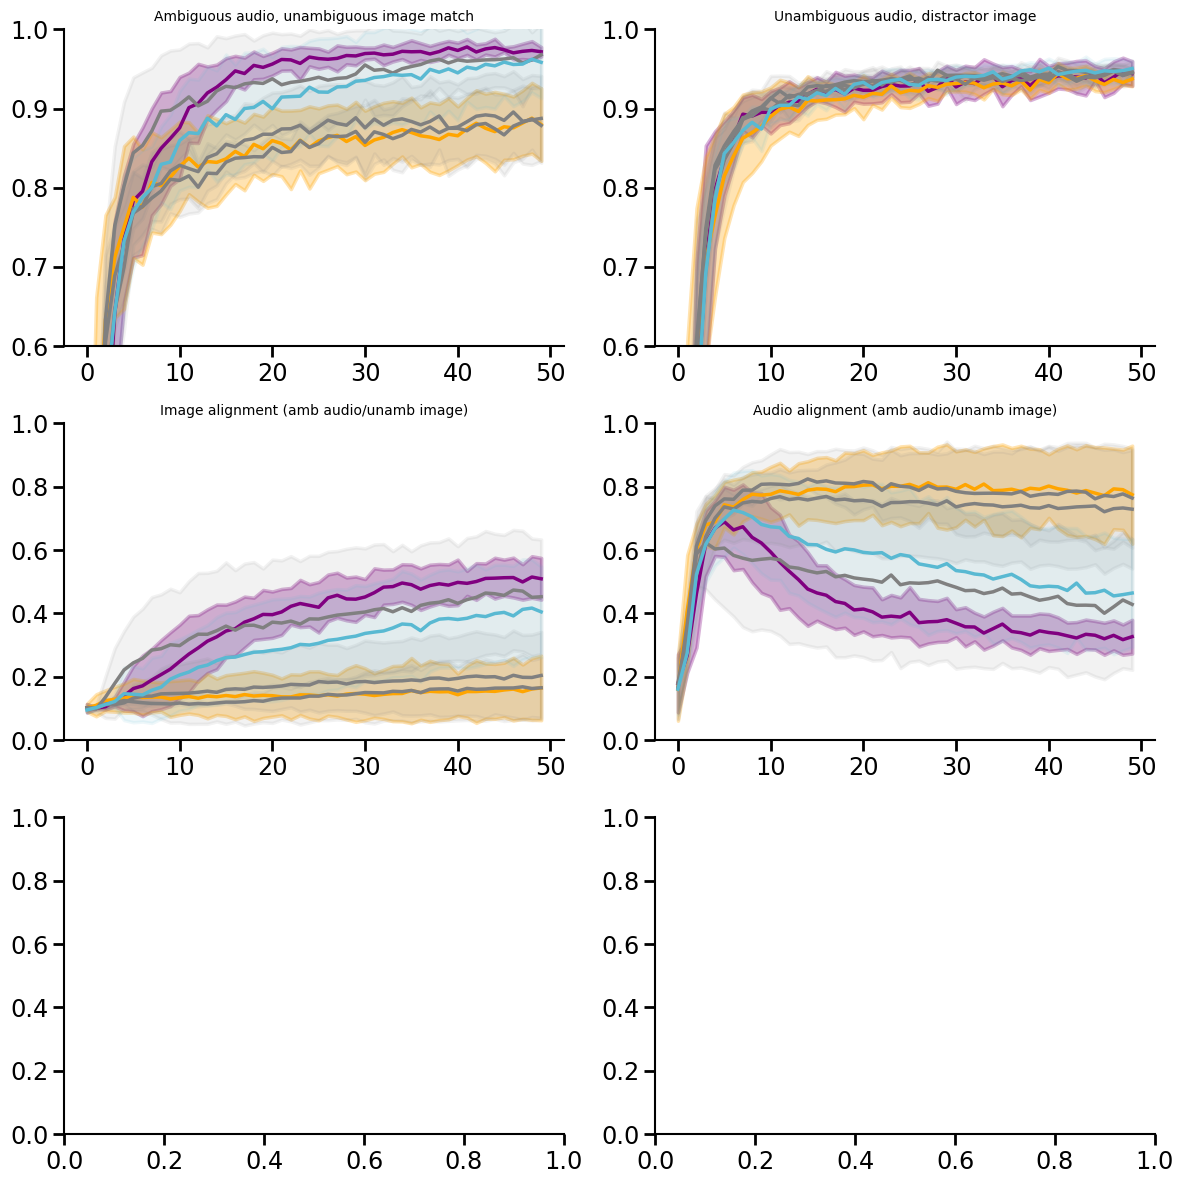

In [13]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'ALL FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
#make_error_plot(ax5, graphs, labels, colors, test_idx=4)
#make_error_plot(ax6, graphs, labels, colors, test_idx=5)

ax1.set_ylim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)
ax3.set_ylim(0, 1.0)
ax4.set_ylim(0, 1.0)

ax1.set_title('Ambiguous audio, unambiguous image match', fontsize='small')
ax2.set_title('Unambiguous audio, distractor image', fontsize='small')
ax3.set_title('Image alignment (amb audio/unamb image)', fontsize='small')
ax4.set_title('Audio alignment (amb audio/unamb image)', fontsize='small')
#ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
#ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('audio_recovery_wFF.pdf')
plt.show()

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


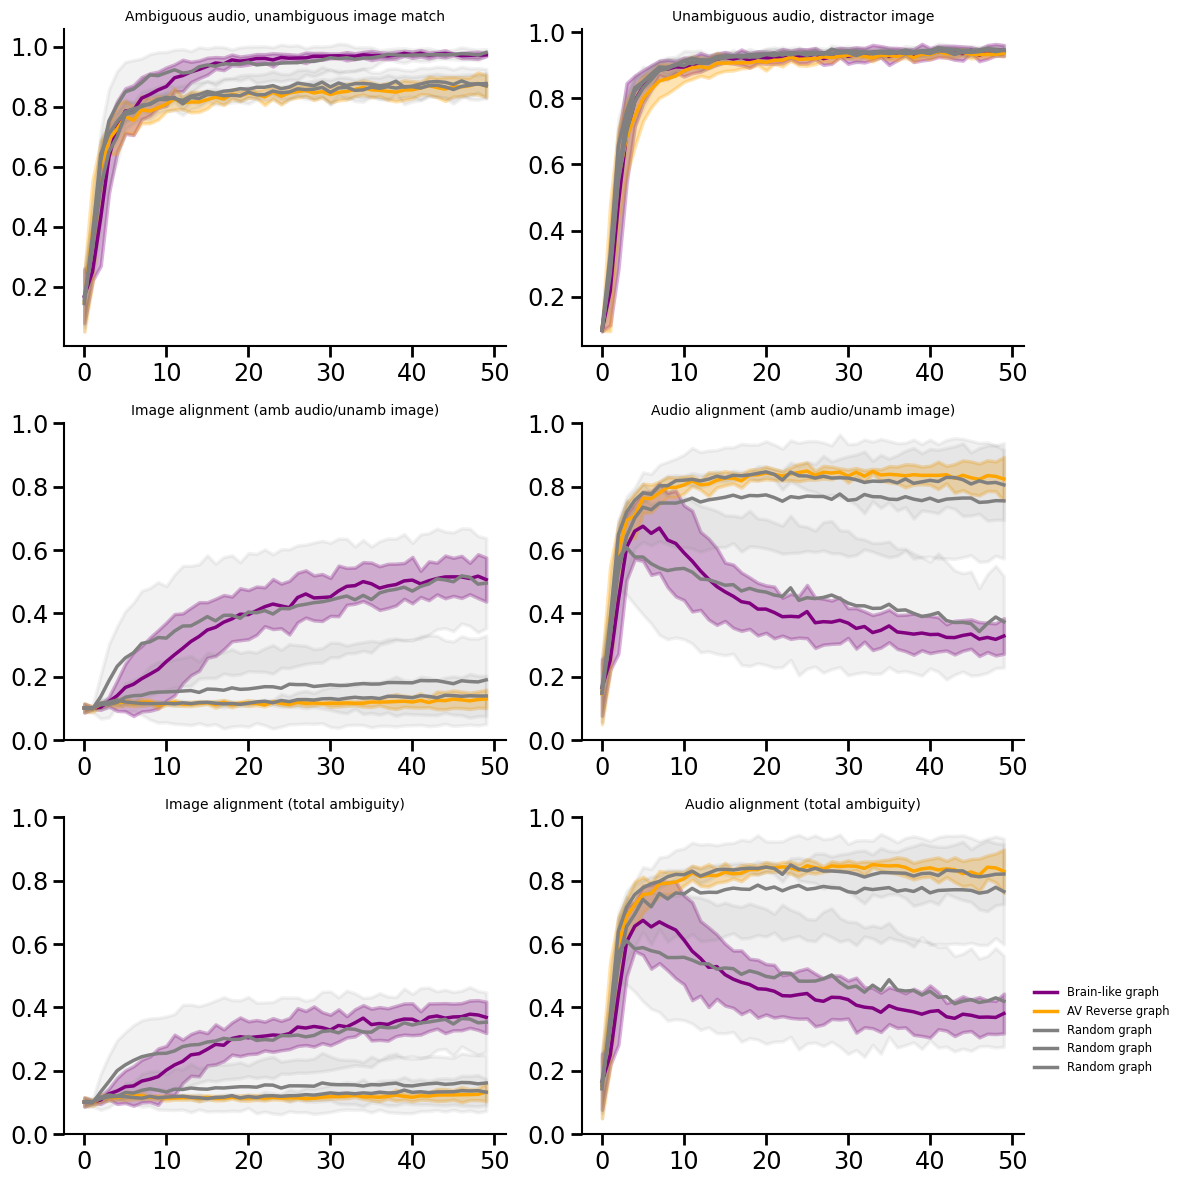

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
make_error_plot(ax5, graphs, labels, colors, test_idx=4)
make_error_plot(ax6, graphs, labels, colors, test_idx=5)

ax3.set_ylim(0, 1.0)
ax4.set_ylim(0, 1.0)
ax5.set_ylim(0, 1.0)
ax6.set_ylim(0, 1.0)

ax1.set_title('Ambiguous audio, unambiguous image match', fontsize='small')
ax2.set_title('Unambiguous audio, distractor image', fontsize='small')
ax3.set_title('Image alignment (amb audio/unamb image)', fontsize='small')
ax4.set_title('Audio alignment (amb audio/unamb image)', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('audio_recovery_mult.pdf')
plt.show()

### Composite topdown

In [32]:
topdown_thickness_comp = []
topdown_mpc_comp = []
topdown_rand1_comp = []
topdown_rand2_comp = []
topdown_rand3_comp = []

for i in range(1, 9):
    topdown_thickness_comp.append(pd.read_pickle('results/ambaudio_brainlike_composite/thickness_{:1d}.npy'.format(i)))
    topdown_mpc_comp.append(pd.read_pickle('results/ambaudio_brainlike_composite/MPC_{:1d}.npy'.format(i)))
    topdown_rand1_comp.append(pd.read_pickle('results/ambaudio_brainlike_composite/random1_{:1d}.npy'.format(i)))
    topdown_rand2_comp.append(pd.read_pickle('results/ambaudio_brainlike_composite/random2_{:1d}.npy'.format(i)))
    topdown_rand3_comp.append(pd.read_pickle('results/ambaudio_brainlike_composite/random3_{:1d}.npy'.format(i)))

In [33]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 50)
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 50)
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 50)
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 50)
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 50)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


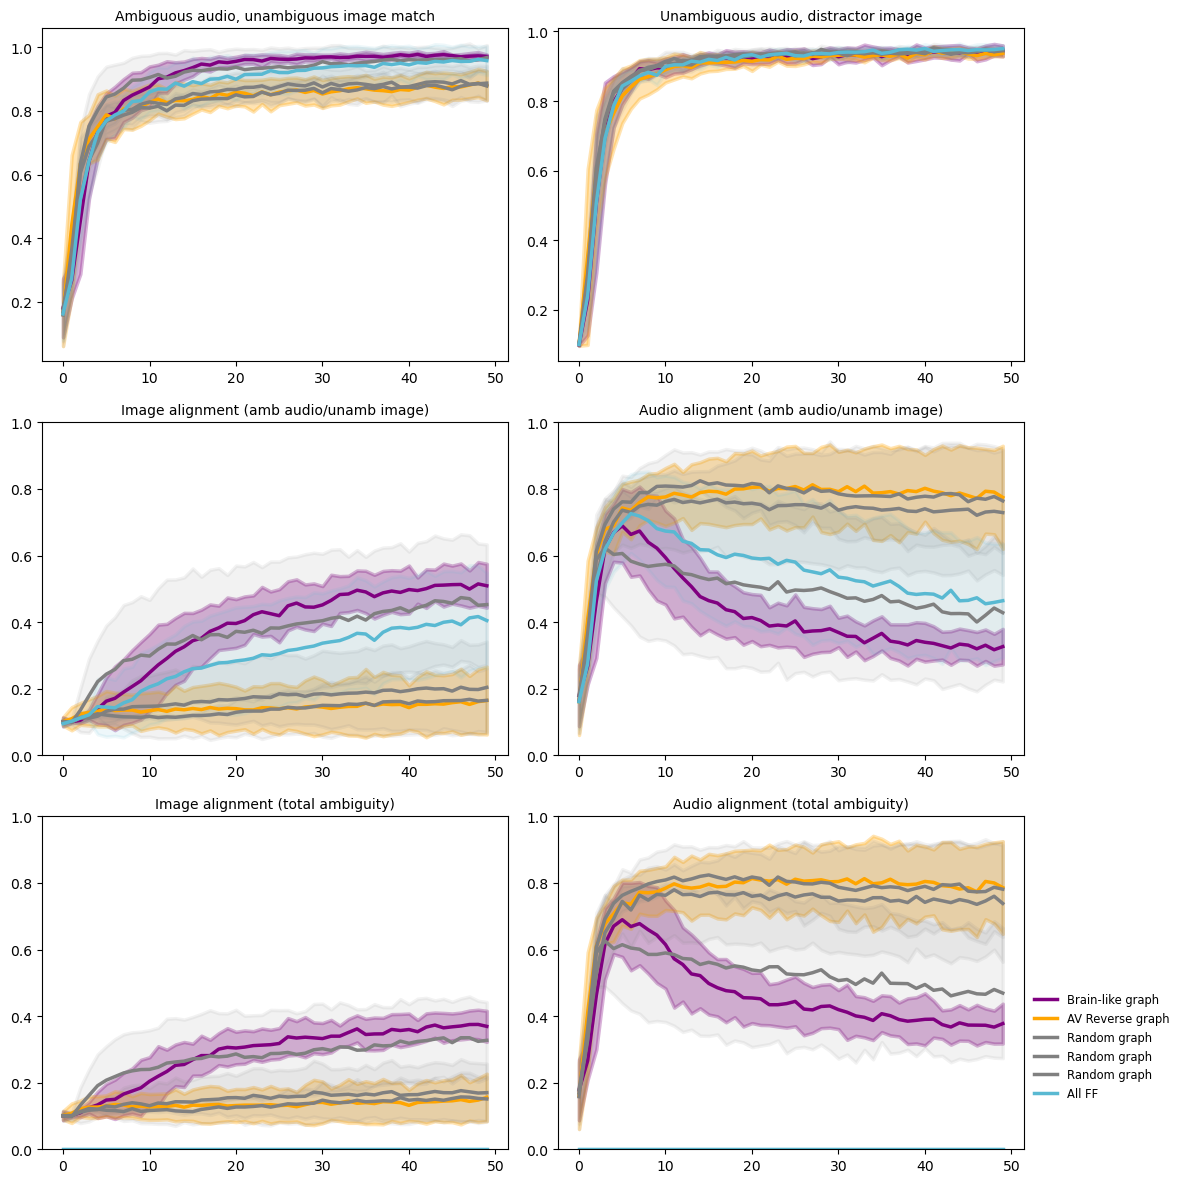

In [34]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'All FF']

make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
make_error_plot(ax5, graphs, labels, colors, test_idx=4)
make_error_plot(ax6, graphs, labels, colors, test_idx=5)
make_error_plot(ax1, graphs, labels, colors, test_idx=0)

#ax1.set_ylim(0.6, 1.0)
#ax2.set_ylim(0.6, 1.0)

ax3.set_ylim(0, 1.0)
ax4.set_ylim(0, 1.0)
ax5.set_ylim(0, 1.0)
ax6.set_ylim(0, 1.0)

ax1.set_title('Ambiguous audio, unambiguous image match', fontsize='small')
ax2.set_title('Unambiguous audio, distractor image', fontsize='small')
ax3.set_title('Image alignment (amb audio/unamb image)', fontsize='small')
ax4.set_title('Audio alignment (amb audio/unamb image)', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('audio_recovery_composite.pdf')
plt.show()

### Comparision

In [16]:
means_mult, means_comp = extract_final_epoch('amb_match_acc')

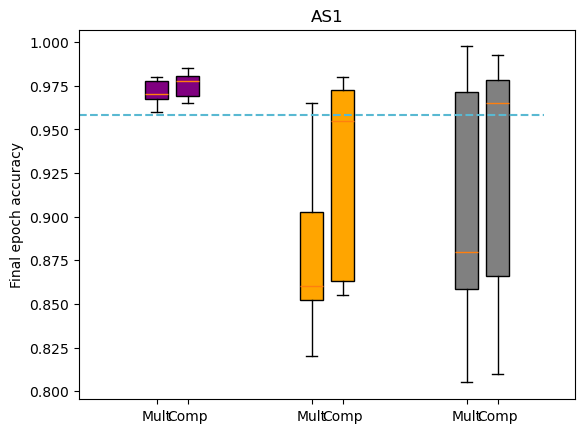

In [17]:
boxplot_mult_vs_comp(means_mult, means_comp, topdown_mff_stats[0][0][49],title='AS1')

In [30]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[0], means_comp[0], equal_var=False)

TtestResult(statistic=-0.8022955570857361, pvalue=0.43757086696912173, df=12.331665308972411)

In [32]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[1], means_comp[1], equal_var=False)

TtestResult(statistic=-2.366935332039797, pvalue=0.03492113751704365, df=12.440747858693044)

In [33]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[2], means_comp[2], equal_var=False)

TtestResult(statistic=-1.0668629041686837, pvalue=0.2916342145901758, df=45.72714076733393)

#### AS2

In [12]:
means_mult, means_comp = extract_final_epoch('clean_mismatch_acc')

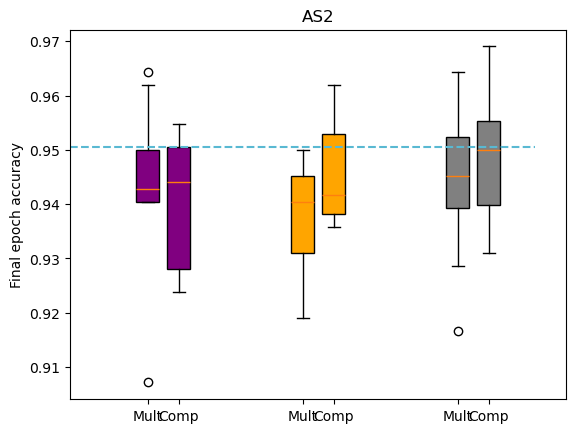

In [13]:
boxplot_mult_vs_comp(means_mult, means_comp, topdown_mff_stats[1][0][49], title='AS2')

In [35]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[0], means_comp[0], equal_var=False)

TtestResult(statistic=0.5478024179061873, pvalue=0.5933701516478206, df=12.639495976017797)

In [36]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[1], means_comp[1], equal_var=False)

TtestResult(statistic=-1.733523765405925, pvalue=0.1050924447074884, df=13.915120859653623)

In [37]:
# Brainlike 
scipy.stats.ttest_ind(means_mult[2], means_comp[2], equal_var=False)

TtestResult(statistic=-0.8668206255408846, pvalue=0.39054542174880014, df=45.93902257797445)

## Double Ambiguity

In [8]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []

for i in range(1, 9):
    topdown_thickness.append(pd.read_pickle('results/double_amb/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/double_amb/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/ambaudio_brainlike/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/ambaudio_brainlike/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/ambaudio_brainlike/random3_{:1d}.npy'.format(i)))

In [9]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 50)
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 50)
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 50)
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 50)
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 50)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


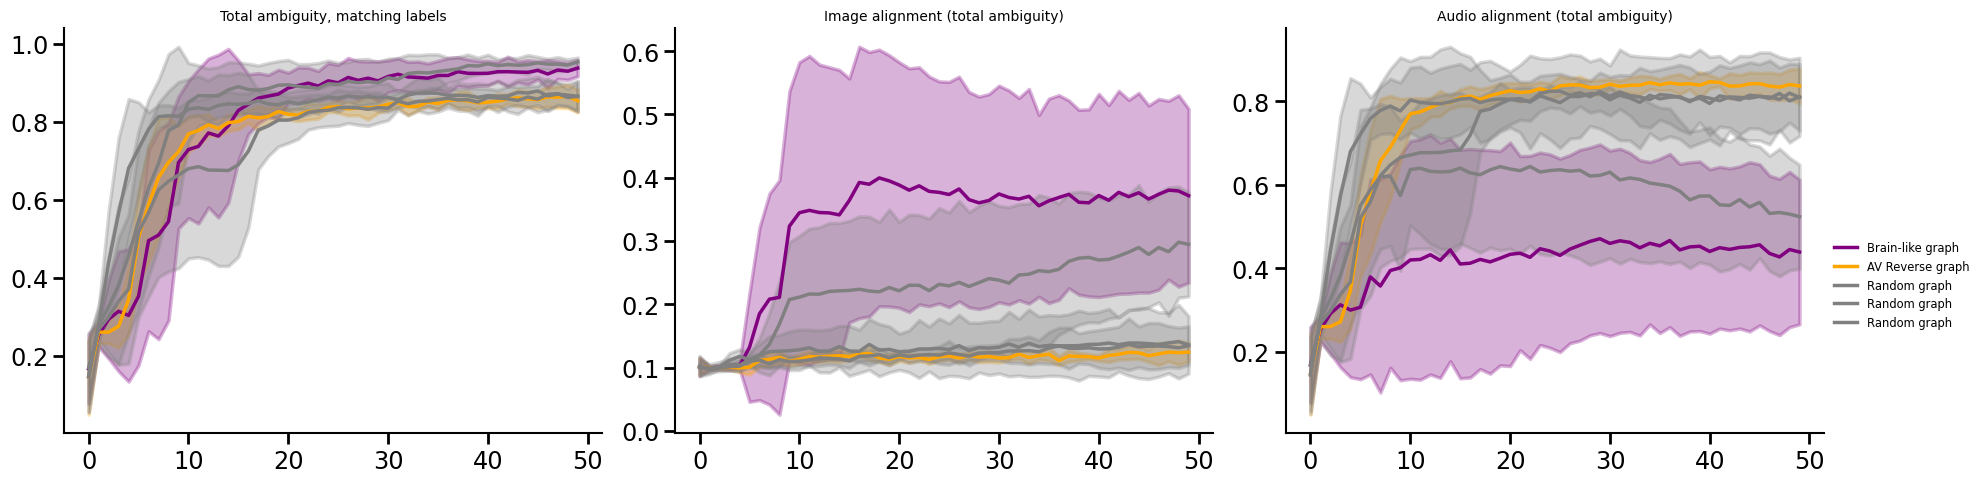

In [10]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=4)
make_error_plot(ax3, graphs, labels, colors, test_idx=5)
#make_error_plot(ax4, graphs, labels, colors, test_idx=3)
#make_error_plot(ax5, graphs, labels, colors, test_idx=4)
#make_error_plot(ax6, graphs, labels, colors, test_idx=5)

ax1.set_title('Total ambiguity, matching labels', fontsize='small')
#ax2.set_title('Unambiguous audio, distractor image', fontsize='small')
#ax3.set_title('Image alignment (amb audio/unamb image)', fontsize='small')
#ax4.set_title('Audio alignment (amb audio/unamb image)', fontsize='small')
ax2.set_title('Image alignment (total ambiguity)', fontsize='small')
ax3.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('10seed_audio.pdf')
plt.show()

## Addition task

In [3]:
topdown_comp = pd.read_pickle('results/topdown_tests/addition/apical1_noupsampling.npy')
topdown_basal = pd.read_pickle('results/topdown_tests/addition/basal10_noupsampling.npy')
topdown_mult = pd.read_pickle('results/topdown_tests/addition/mult_noupsampling.npy')
all_topdown = pd.read_pickle('results/topdown_tests/addition/all_noupsampling.npy')
#no_topdown = pd.read_pickle('results/topdown_tests/topdown_only_noupsampling_control.npy')

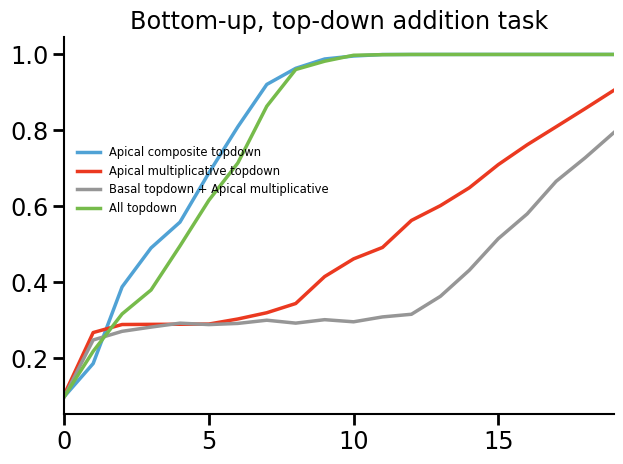

In [7]:
fig, ax1 = plt.subplots()
plot_utils.linclab_plt_defaults()
ax1.plot(topdown_comp['val_acc'], label='Apical composite topdown')
ax1.plot(topdown_mult['val_acc'], label='Apical multiplicative topdown')
#ax1.plot(topdown_basal['val_acc'], label='Small basal topdown + Apical multiplicative')
ax1.plot(topdown_basal['val_acc'], label='Basal topdown + Apical multiplicative')
ax1.plot(all_topdown['val_acc'], label='All topdown')
#ax1.plot(no_topdown['val_acc'], label='No topdown')
plt.title('Bottom-up, top-down addition task (train)')
plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[0.5,0.5])
ax1.set_xlim([0, 19])
plt.show()

# 4 task training

In [9]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []
topdown_mff = []

for i in range(1, 20):
    topdown_thickness.append(pd.read_pickle('results/4task/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/4task/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/4task/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/4task/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/4task/random3_{:1d}.npy'.format(i)))
    topdown_mff.append(pd.read_pickle('results/4task/big_rnn_{:1d}.npy'.format(i)))

In [10]:
scenarios= ['vs1_acc', 'vs2_acc', 'as1_acc', 'as2_acc', 'control_img_align', 'control_audio_align']

In [11]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 50, scenarios=scenarios)
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 50,scenarios=scenarios)
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 50,scenarios=scenarios)
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 50,scenarios=scenarios)
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 50,scenarios=scenarios)
topdown_mff_stats = extract_mean_and_std_V2(topdown_mff, 50,scenarios=scenarios)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


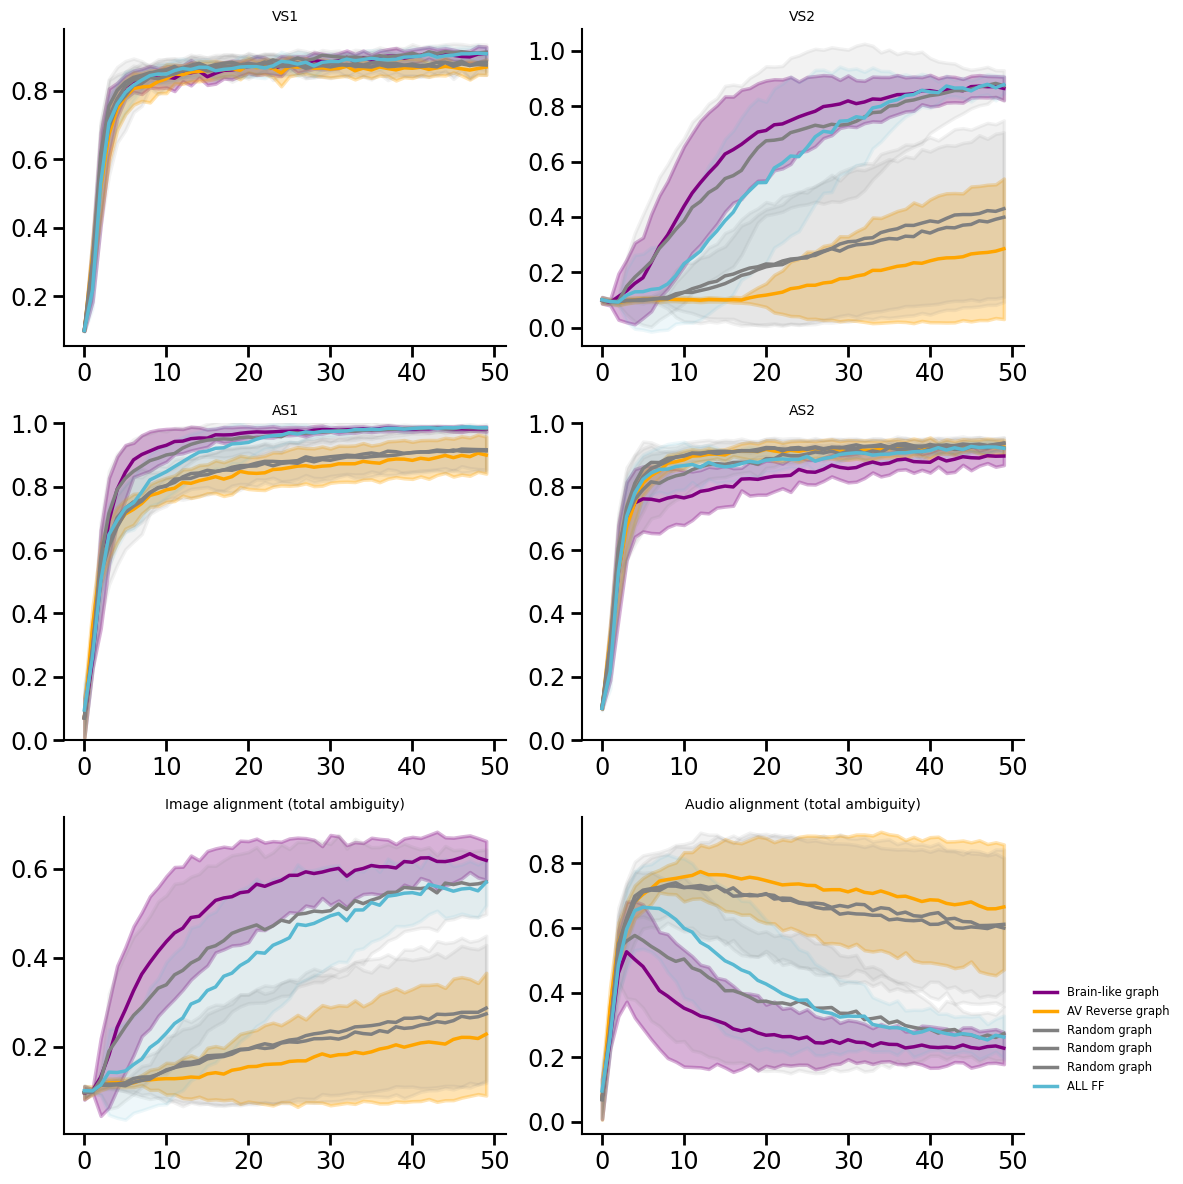

In [18]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'ALL FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
make_error_plot(ax5, graphs, labels, colors, test_idx=4)
make_error_plot(ax6, graphs, labels, colors, test_idx=5)

#ax1.set_ylim(0.6, 1.0)
#ax2.set_ylim(0.6, 1.0)
ax3.set_ylim(0, 1.0)
ax4.set_ylim(0, 1.0)

ax1.set_title('VS1', fontsize='small')
ax2.set_title('VS2', fontsize='small')
ax3.set_title('AS1', fontsize='small')
ax4.set_title('AS2', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('recovery_4task.pdf')
plt.show()

## Composite

In [41]:
topdown_thickness = []
topdown_mpc = []
topdown_rand1 = []
topdown_rand2 = []
topdown_rand3 = []
topdown_mff = []

for i in range(1, 14):
    topdown_thickness.append(pd.read_pickle('results/4task_composite/thickness_{:1d}.npy'.format(i)))
    topdown_mpc.append(pd.read_pickle('results/4task_composite/MPC_{:1d}.npy'.format(i)))
    topdown_rand1.append(pd.read_pickle('results/4task_composite/random1_{:1d}.npy'.format(i)))
    topdown_rand2.append(pd.read_pickle('results/4task_composite/random2_{:1d}.npy'.format(i)))
    topdown_rand3.append(pd.read_pickle('results/4task_composite/random3_{:1d}.npy'.format(i)))
    topdown_mff.append(pd.read_pickle('results/4task/big_rnn_{:1d}.npy'.format(i)))

In [42]:
topdown_thickness_stats = extract_mean_and_std_V2(topdown_thickness, 50, scenarios=scenarios)
topdown_mpc_stats = extract_mean_and_std_V2(topdown_mpc, 50,scenarios=scenarios)
topdown_rand1_stats = extract_mean_and_std_V2(topdown_rand1, 50,scenarios=scenarios)
topdown_rand2_stats = extract_mean_and_std_V2(topdown_rand2, 50,scenarios=scenarios)
topdown_rand3_stats = extract_mean_and_std_V2(topdown_rand3, 50,scenarios=scenarios)
topdown_mff_stats = extract_mean_and_std_V2(topdown_mff, 50,scenarios=scenarios)

/home/mila/m/mashbayar.tugsbayar/linclab_utils/linclab_utils/plot_utils.py:309: UserWarning: Requested font(s) not found: Liberation Sans.
Font set to sans-serif family.
  warnings.warn(f"Requested font(s) not found: {omitted_str}."


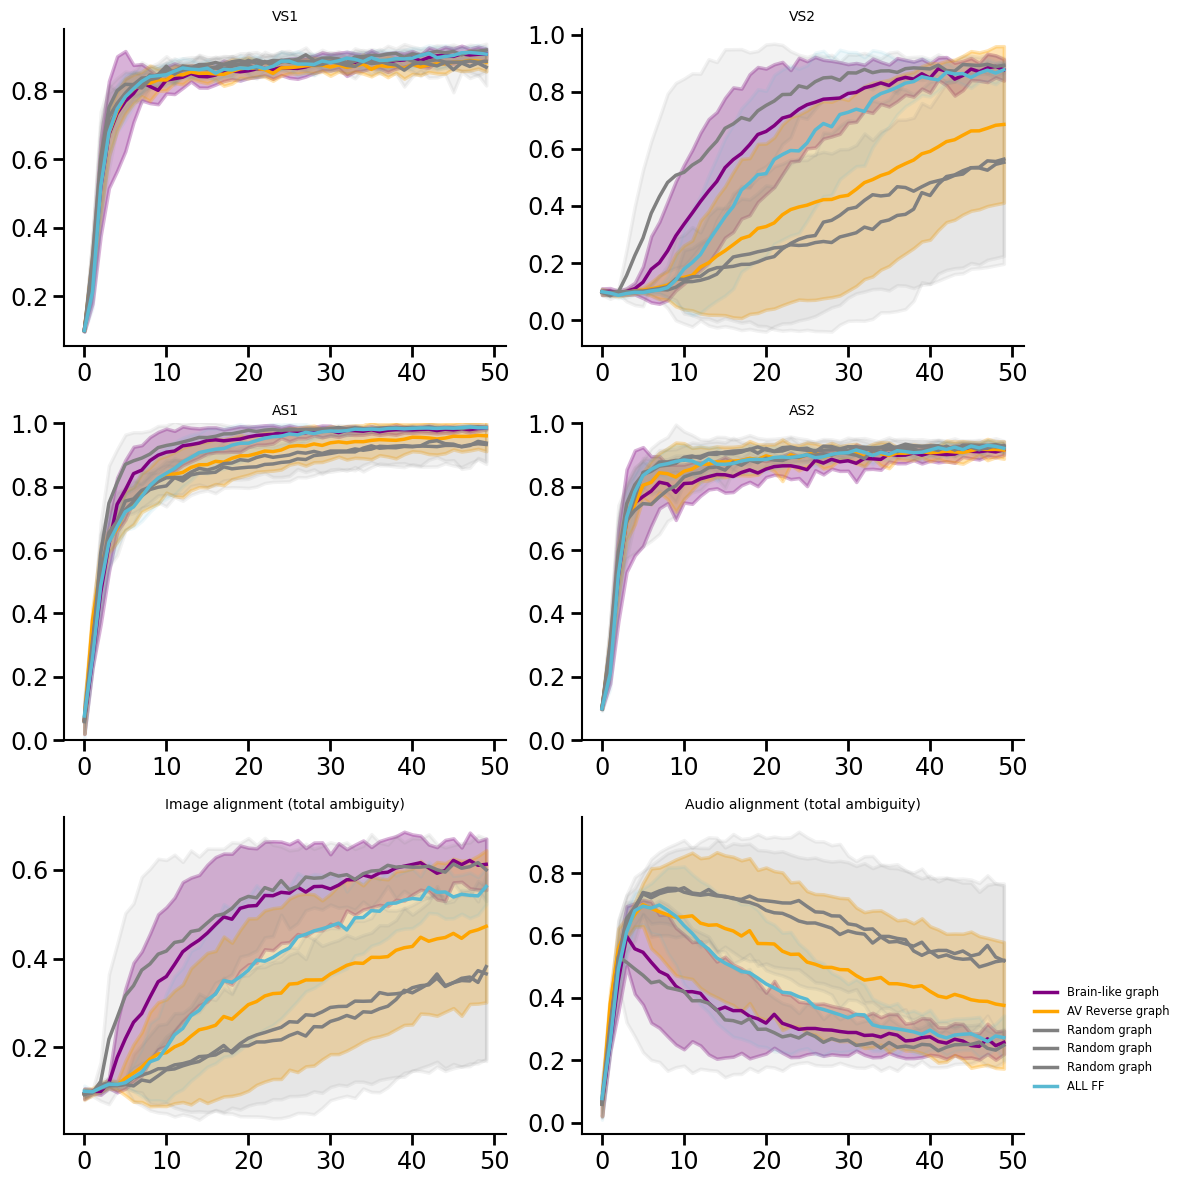

In [44]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
plot_utils.linclab_plt_defaults()
graphs = [topdown_thickness_stats, topdown_mpc_stats, topdown_rand1_stats, topdown_rand2_stats, topdown_rand3_stats, topdown_mff_stats]
colors = ['purple', 'orange', 'gray', 'gray', 'gray', '#59B9D2']
labels = ['Brain-like graph', 'AV Reverse graph', 'Random graph', 'Random graph', 'Random graph', 'ALL FF']

make_error_plot(ax1, graphs, labels, colors, test_idx=0)
make_error_plot(ax2, graphs, labels, colors, test_idx=1)
make_error_plot(ax3, graphs, labels, colors, test_idx=2)
make_error_plot(ax4, graphs, labels, colors, test_idx=3)
make_error_plot(ax5, graphs, labels, colors, test_idx=4)
make_error_plot(ax6, graphs, labels, colors, test_idx=5)

#ax1.set_ylim(0.6, 1.0)
#ax2.set_ylim(0.6, 1.0)
ax3.set_ylim(0, 1.0)
ax4.set_ylim(0, 1.0)

ax1.set_title('VS1', fontsize='small')
ax2.set_title('VS2', fontsize='small')
ax3.set_title('AS1', fontsize='small')
ax4.set_title('AS2', fontsize='small')
ax5.set_title('Image alignment (total ambiguity)', fontsize='small')
ax6.set_title('Audio alignment (total ambiguity)', fontsize='small')

plt.legend(fontsize='x-small', frameon=False, bbox_to_anchor=[1,0.5])
plt.savefig('recovery_4task_composite.pdf')
plt.show()